## Part 3: Models with Convolutional Layers

### Preparation:
1. Define the ConvolutionalLayer and implementation of fprop for convolutional layer, outputs are calculated only for 'valid' overlaps of the kernel filters with the input - i.e. without any padding. It is also assumed that if convolutions with non-unit strides are implemented the default behaviour is to take unit-strides, with the test cases only correct for unit strides in both directions.
2. The three test functions are defined in the cell below. All the functions take as first argument the class corresponding to the convolutional layer implementation to be tested (not an instance of the class). It is assumed the class being tested has an __init__ method with at least all of the arguments defined in the skeleton definition above. A boolean second argument to each function can be used to specify if the layer implements a cross-correlation or convolution based operation (see note in seventh lecture slides). An example of using the test functions if given in the cell below. This assumes you implement a convolution (rather than cross-correlation) operation. If the implementation is correct.
3. Set up  
   the data providers  
   a penalty object has been assigned to weights_penalty 
   a seeded random number generator assigned to rng.  
   logger objects needed for training runs.  
   train the model using default parameteor below  
   num_epochs = 50  
   stats_interval = 5  
   batch_size = 50  
   learning_rate = 0.01  
   mom_coeff = 0.9   
   weights_init_gain = 0.5  
   biases_init = 0.  
   input_dim, output_dim, hidden_dim = 784, 10, 100  

In [1]:
import mlp.layers as layers
import mlp.initialisers as init
from scipy.signal import convolve2d as conv2d 
from scipy.ndimage.interpolation import rotate
class ConvolutionalLayer(layers.LayerWithParameters):
    """Layer implementing a 2D convolution-based transformation of its inputs.

    The layer is parameterised by a set of 2D convolutional kernels, a four
    dimensional array of shape
        (num_output_channels, num_input_channels, kernel_dim_1, kernel_dim_2)
    and a bias vector, a one dimensional array of shape
        (num_output_channels,)
    i.e. one shared bias per output channel.

    Assuming no-padding is applied to the inputs so that outputs are only
    calculated for positions where the kernel filters fully overlap with the
    inputs, and that unit strides are used the outputs will have spatial extent
        output_dim_1 = input_dim_1 - kernel_dim_1 + 1
        output_dim_2 = input_dim_2 - kernel_dim_2 + 1
    """

    def __init__(self, num_input_channels, num_output_channels,
                 input_dim_1, input_dim_2,
                 kernel_dim_1, kernel_dim_2,
                 kernels_init=init.UniformInit(-0.01, 0.01),
                 biases_init=init.ConstantInit(0.),
                 kernels_penalty=None, biases_penalty=None):
        """Initialises a parameterised convolutional layer.

        Args:
            num_input_channels (int): Number of channels in inputs to
                layer (this may be number of colour channels in the input
                images if used as the first layer in a model, or the
                number of output channels, a.k.a. feature maps, from a
                a previous convolutional layer).
            num_output_channels (int): Number of channels in outputs
                from the layer, a.k.a. number of feature maps.
            input_dim_1 (int): Size of first input dimension of each 2D
                channel of inputs.
            input_dim_2 (int): Size of second input dimension of each 2D
                channel of inputs.
            kernel_dim_x (int): Size of first dimension of each 2D channel of
                kernels.
            kernel_dim_y (int): Size of second dimension of each 2D channel of
                kernels.
            kernels_intialiser: Initialiser for the kernel parameters.
            biases_initialiser: Initialiser for the bias parameters.
            kernels_penalty: Kernel-dependent penalty term (regulariser) or
                None if no regularisation is to be applied to the kernels.
            biases_penalty: Biases-dependent penalty term (regulariser) or
                None if no regularisation is to be applied to the biases.
        """
        self.num_input_channels = num_input_channels
        self.num_output_channels = num_output_channels
        self.input_dim_1 = input_dim_1
        self.input_dim_2 = input_dim_2
        self.kernel_dim_1 = kernel_dim_1
        self.kernel_dim_2 = kernel_dim_2
        self.kernels_init = kernels_init
        self.biases_init = biases_init
        self.kernels_shape = (
            num_output_channels, num_input_channels, kernel_dim_1, kernel_dim_2
        )
        self.inputs_shape = (
            None, num_input_channels, input_dim_1, input_dim_2
        )
        self.kernels = self.kernels_init(self.kernels_shape)
        self.biases = self.biases_init(num_output_channels)
        self.kernels_penalty = kernels_penalty
        self.biases_penalty = biases_penalty

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x`, outputs `y`, kernels `K` and biases `b` the layer
        corresponds to `y = conv2d(x, K) + b`.

        Args:
            inputs: Array of layer inputs of shape 
                (batch_size, num_input_channels, input_dim_1, input_dim_2).

        Returns:
            outputs: Array of layer outputs of shape 
                (batch_size, num_output_channels, output_dim_1, output_dim_2).
        """
        outputs = []
        for batch in xrange(inputs.shape[0]):   
            outputs_temp = []
            for num_output_c in xrange(self.num_output_channels):
                output = 0.
                for num_input_c in xrange(self.num_input_channels):
                    output += conv2d(inputs[batch][num_input_c], self.kernels[num_output_c][num_input_c], mode = 'valid')
                output += self.biases[num_output_c]
                outputs_temp.append(output)
            outputs.append(outputs_temp)  
        return np.array(outputs)

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.

        Args:
            inputs: Array of layer inputs of shape
                (batch_size, num_input_channels, input_dim_1, input_dim_2).
            outputs: Array of layer outputs calculated in forward pass of
                shape
                (batch_size, num_output_channels, output_dim_1, output_dim_2).
            grads_wrt_outputs: Array of gradients with respect to the layer
                outputs of shape
                (batch_size, num_output_channels, output_dim_1, output_dim_2).

        Returns:
            Array of gradients with respect to the layer inputs of shape
            (batch_size, num_input_channels, input_dim_1, input_dim_2).
        """
        outputs = []
        for batch in xrange(grads_wrt_outputs.shape[0]): 
            outputs_temp = []
            for num_input_c in xrange(self.num_input_channels):
                output = 0.
                for num_output_c in xrange(self.num_output_channels):
                    output += conv2d(grads_wrt_outputs[batch][num_output_c], 
                                     rotate(rotate(self.kernels[num_output_c][num_input_c], 90.0), 90),  
                                            mode = 'full')
                outputs_temp.append(output)
            outputs.append(outputs_temp)  
        return np.array(outputs)
                                     
    def grads_wrt_params(self, inputs, grads_wrt_outputs):
        """Calculates gradients with respect to layer parameters.

        Args:
            inputs: array of inputs to layer of shape (batch_size, input_dim)
            grads_wrt_to_outputs: array of gradients with respect to the layer
                outputs of shape
                (batch_size, num_output_channels, output_dim_1, output_dim_2).

        Returns:
            list of arrays of gradients with respect to the layer parameters
            `[grads_wrt_kernels, grads_wrt_biases]`.
        """
        grads_wrt_kernels = np.zeros((self.num_output_channels, self.num_input_channels, self.kernel_dim_1, self.kernel_dim_2))
        grads_wrt_biases = np.zeros(self.num_output_channels)
        for batch in xrange(grads_wrt_outputs.shape[0]):
            for num_output_channels in xrange(self.num_output_channels):
                grads_wrt_biases[num_output_channels] += grads_wrt_outputs[batch][num_output_channels].sum()
                for num_input_channels in xrange(self.num_input_channels):
                    grads_wrt_kernels[num_output_channels, num_input_channels] += conv2d(grads_wrt_outputs[batch,num_output_channels], rotate(rotate(inputs[batch, num_input_channels], 90.0), 90.0), mode = 'valid')
        return [np.array(grads_wrt_kernels), np.array(grads_wrt_biases)]

    def params_penalty(self):
        """Returns the parameter dependent penalty term for this layer.

        If no parameter-dependent penalty terms are set this returns zero.
        """
        params_penalty = 0
        if self.kernels_penalty is not None:
            params_penalty += self.kernels_penalty(self.kernels)
        if self.biases_penalty is not None:
            params_penalty += self.biases_penalty(self.biases)
        return params_penalty

    @property
    def params(self):
        """A list of layer parameter values: `[kernels, biases]`."""
        return [self.kernels, self.biases]
    
    @params.setter
    def params(self, values):
        self.kernels = values[0]
        self.biases = values[1]

    def __repr__(self):
        return (
            'ConvolutionalLayer(\n'
            '    num_input_channels={0}, num_output_channels={1},\n'
            '    input_dim_1={2}, input_dim_2={3},\n'
            '    kernel_dim_1={4}, kernel_dim_2={5}\n'
            ')'
            .format(self.num_input_channels, self.num_output_channels,
                    self.input_dim_1, self.input_dim_2, self.kernel_dim_1,
                    self.kernel_dim_2)
        )

In [2]:
import numpy as np

def test_conv_layer_fprop(layer_class, do_cross_correlation=False):
    """Tests `fprop` method of a convolutional layer.
    
    Checks the outputs of `fprop` method for a fixed input against known
    reference values for the outputs and raises an AssertionError if
    the outputted values are not consistent with the reference values. If
    tests are all passed returns True.
    
    Args:
        layer_class: Convolutional layer implementation following the 
            interface defined in the provided skeleton class.
        do_cross_correlation: Whether the layer implements an operation
            corresponding to cross-correlation (True) i.e kernels are
            not flipped before sliding over inputs, or convolution
            (False) with filters being flipped.

    Raises:
        AssertionError: Raised if output of `layer.fprop` is inconsistent 
            with reference values either in shape or values.
    """
    inputs = np.arange(96).reshape((2, 3, 4, 4))
    kernels = np.arange(-12, 12).reshape((2, 3, 2, 2))
    if do_cross_correlation:
        kernels = kernels[:, :, ::-1, ::-1]
    biases = np.arange(2)
    true_output = np.array(
        [[[[ -958., -1036., -1114.],
           [-1270., -1348., -1426.],
           [-1582., -1660., -1738.]],
          [[ 1707.,  1773.,  1839.],
           [ 1971.,  2037.,  2103.],
           [ 2235.,  2301.,  2367.]]],
         [[[-4702., -4780., -4858.],
           [-5014., -5092., -5170.],
           [-5326., -5404., -5482.]],
          [[ 4875.,  4941.,  5007.],
           [ 5139.,  5205.,  5271.],
           [ 5403.,  5469.,  5535.]]]]
    )
    layer = layer_class(
        num_input_channels=kernels.shape[1], 
        num_output_channels=kernels.shape[0], 
        input_dim_1=inputs.shape[2], 
        input_dim_2=inputs.shape[3],
        kernel_dim_1=kernels.shape[2],
        kernel_dim_2=kernels.shape[3]
    )
    layer.params = [kernels, biases]
    layer_output = layer.fprop(inputs)
    assert layer_output.shape == true_output.shape, (
        'Layer fprop gives incorrect shaped output. '
        'Correct shape is \n\n{0}\n\n but returned shape is \n\n{1}.'
        .format(true_output.shape, layer_output.shape)
    )
    assert np.allclose(layer_output, true_output), (
        'Layer fprop does not give correct output. '
        'Correct output is \n\n{0}\n\n but returned output is \n\n{1}.'
        .format(true_output, layer_output)
    )
    return True

def test_conv_layer_bprop(layer_class, do_cross_correlation=False):
    """Tests `bprop` method of a convolutional layer.
    
    Checks the outputs of `bprop` method for a fixed input against known
    reference values for the gradients with respect to inputs and raises 
    an AssertionError if the returned values are not consistent with the
    reference values. If tests are all passed returns True.
    
    Args:
        layer_class: Convolutional layer implementation following the 
            interface defined in the provided skeleton class.
        do_cross_correlation: Whether the layer implements an operation
            corresponding to cross-correlation (True) i.e kernels are
            not flipped before sliding over inputs, or convolution
            (False) with filters being flipped.

    Raises:
        AssertionError: Raised if output of `layer.bprop` is inconsistent 
            with reference values either in shape or values.
    """
    inputs = np.arange(96).reshape((2, 3, 4, 4))
    kernels = np.arange(-12, 12).reshape((2, 3, 2, 2))
    if do_cross_correlation:
        kernels = kernels[:, :, ::-1, ::-1]
    biases = np.arange(2)
    grads_wrt_outputs = np.arange(-20, 16).reshape((2, 2, 3, 3))
    outputs = np.array(
        [[[[ -958., -1036., -1114.],
           [-1270., -1348., -1426.],
           [-1582., -1660., -1738.]],
          [[ 1707.,  1773.,  1839.],
           [ 1971.,  2037.,  2103.],
           [ 2235.,  2301.,  2367.]]],
         [[[-4702., -4780., -4858.],
           [-5014., -5092., -5170.],
           [-5326., -5404., -5482.]],
          [[ 4875.,  4941.,  5007.],
           [ 5139.,  5205.,  5271.],
           [ 5403.,  5469.,  5535.]]]]
    )
    true_grads_wrt_inputs = np.array(
      [[[[ 147.,  319.,  305.,  162.],
         [ 338.,  716.,  680.,  354.],
         [ 290.,  608.,  572.,  294.],
         [ 149.,  307.,  285.,  144.]],
        [[  23.,   79.,   81.,   54.],
         [ 114.,  284.,  280.,  162.],
         [ 114.,  272.,  268.,  150.],
         [  73.,  163.,  157.,   84.]],
        [[-101., -161., -143.,  -54.],
         [-110., -148., -120.,  -30.],
         [ -62.,  -64.,  -36.,    6.],
         [  -3.,   19.,   29.,   24.]]],
       [[[  39.,   67.,   53.,   18.],
         [  50.,   68.,   32.,   -6.],
         [   2.,  -40.,  -76.,  -66.],
         [ -31.,  -89., -111.,  -72.]],
        [[  59.,  115.,  117.,   54.],
         [ 114.,  212.,  208.,   90.],
         [ 114.,  200.,  196.,   78.],
         [  37.,   55.,   49.,   12.]],
        [[  79.,  163.,  181.,   90.],
         [ 178.,  356.,  384.,  186.],
         [ 226.,  440.,  468.,  222.],
         [ 105.,  199.,  209.,   96.]]]])
    layer = layer_class(
        num_input_channels=kernels.shape[1], 
        num_output_channels=kernels.shape[0], 
        input_dim_1=inputs.shape[2], 
        input_dim_2=inputs.shape[3],
        kernel_dim_1=kernels.shape[2],
        kernel_dim_2=kernels.shape[3]
    )
    layer.params = [kernels, biases]
    layer_grads_wrt_inputs = layer.bprop(inputs, outputs, grads_wrt_outputs)
    assert layer_grads_wrt_inputs.shape == true_grads_wrt_inputs.shape, (
        'Layer bprop returns incorrect shaped array. '
        'Correct shape is \n\n{0}\n\n but returned shape is \n\n{1}.'
        .format(true_grads_wrt_inputs.shape, layer_grads_wrt_inputs.shape)
    )
    assert np.allclose(layer_grads_wrt_inputs, true_grads_wrt_inputs), (
        'Layer bprop does not return correct values. '
        'Correct output is \n\n{0}\n\n but returned output is \n\n{1}'
        .format(true_grads_wrt_inputs, layer_grads_wrt_inputs)
    )
    return True

def test_conv_layer_grad_wrt_params(
        layer_class, do_cross_correlation=False):
    """Tests `grad_wrt_params` method of a convolutional layer.
    
    Checks the outputs of `grad_wrt_params` method for fixed inputs 
    against known reference values for the gradients with respect to 
    kernels and biases, and raises an AssertionError if the returned
    values are not consistent with the reference values. If tests
    are all passed returns True.
    
    Args:
        layer_class: Convolutional layer implementation following the 
            interface defined in the provided skeleton class.
        do_cross_correlation: Whether the layer implements an operation
            corresponding to cross-correlation (True) i.e kernels are
            not flipped before sliding over inputs, or convolution
            (False) with filters being flipped.

    Raises:
        AssertionError: Raised if output of `layer.bprop` is inconsistent 
            with reference values either in shape or values.
    """
    inputs = np.arange(96).reshape((2, 3, 4, 4))
    kernels = np.arange(-12, 12).reshape((2, 3, 2, 2))
    biases = np.arange(2)
    grads_wrt_outputs = np.arange(-20, 16).reshape((2, 2, 3, 3))
    true_kernel_grads = np.array(
        [[[[ -240.,  -114.],
         [  264.,   390.]],
        [[-2256., -2130.],
         [-1752., -1626.]],
        [[-4272., -4146.],
         [-3768., -3642.]]],
       [[[ 5268.,  5232.],
         [ 5124.,  5088.]],
        [[ 5844.,  5808.],
         [ 5700.,  5664.]],
        [[ 6420.,  6384.],
         [ 6276.,  6240.]]]])
    if do_cross_correlation:
        kernels = kernels[:, :, ::-1, ::-1]
        true_kernel_grads = true_kernel_grads[:, :, ::-1, ::-1]
    true_bias_grads = np.array([-126.,   36.])
    layer = layer_class(
        num_input_channels=kernels.shape[1], 
        num_output_channels=kernels.shape[0], 
        input_dim_1=inputs.shape[2], 
        input_dim_2=inputs.shape[3],
        kernel_dim_1=kernels.shape[2],
        kernel_dim_2=kernels.shape[3]
    )
    layer.params = [kernels, biases]
    layer_kernel_grads, layer_bias_grads = (
        layer.grads_wrt_params(inputs, grads_wrt_outputs))
    assert layer_kernel_grads.shape == true_kernel_grads.shape, (
        'grads_wrt_params gives incorrect shaped kernel gradients output. '
        'Correct shape is \n\n{0}\n\n but returned shape is \n\n{1}.'
        .format(true_kernel_grads.shape, layer_kernel_grads.shape)
    )
    assert np.allclose(layer_kernel_grads, true_kernel_grads), (
        'grads_wrt_params does not give correct kernel gradients output. '
        'Correct output is \n\n{0}\n\n but returned output is \n\n{1}.'
        .format(true_kernel_grads, layer_kernel_grads)
    )
    assert layer_bias_grads.shape == true_bias_grads.shape, (
        'grads_wrt_params gives incorrect shaped bias gradients output. '
        'Correct shape is \n\n{0}\n\n but returned shape is \n\n{1}.'
        .format(true_bias_grads.shape, layer_bias_grads.shape)
    )
    assert np.allclose(layer_bias_grads, true_bias_grads), (
        'grads_wrt_params does not give correct bias gradients output. '
        'Correct output is \n\n{0}\n\n but returned output is \n\n{1}.'
        .format(true_bias_grads, layer_bias_grads)
    )
    return True

In [3]:
all_correct = test_conv_layer_fprop(ConvolutionalLayer, False)
all_correct &= test_conv_layer_bprop(ConvolutionalLayer, False)
all_correct &= test_conv_layer_grad_wrt_params(ConvolutionalLayer, False)
if all_correct:
    print('All tests passed.')

All tests passed.


In [4]:
import numpy as np
from collections import OrderedDict
import logging
from mlp.layers import AffineLayer, ReshapeLayer, MaxPoolingLayer, SigmoidLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser

In [5]:
# Seed a random number generator
seed = 24102016 
rng = np.random.RandomState(seed)

num_epochs = 50
stats_interval = 5
batch_size = 50
learning_rate = 0.01
mom_coeff = 0.9
weights_init_gain = 0.5
biases_init = 0.
input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(weights_init_gain, rng)
biases_init = ConstantInit(biases_init)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size, rng=rng)

train_data.batch_size = batch_size 
valid_data.batch_size = batch_size


### Experiment 3:  
1. Train the 5 different model(ajust the parameter or other ajustment)
2. Plot the training set error against epoch number for all different models on the same axis. On a second axis plot the validation set error against epoch number for all the different models

In [6]:
input_dim_1 = 28
input_dim_2 = 28
hidden_dim = 100
num_input_channels = 1
num_output_channels = 1
kernel_dim_1 = 5
kernel_dim_2 = 5

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()
print('Kernel dim: {0}'.format(kernel_dim_1))
model = MultipleLayerModel([
    ReshapeLayer((1, 28, 28)),
    ConvolutionalLayer(num_input_channels, num_output_channels, input_dim_1, input_dim_2, kernel_dim_1, kernel_dim_2),
    MaxPoolingLayer(4),
    ReshapeLayer(),
    AffineLayer(((input_dim_1 - kernel_dim_1 + 1) ** 2) / 4, hidden_dim, weights_init, 
                biases_init),
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, 
                biases_init),
    SigmoidLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, 
                biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors)

aug_stats1, aug_keys1, aug_run_time1 = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

Kernel dim: 5


Epoch 5: 35.43s to complete
  error(train)=1.55e-01, acc(train)=9.56e-01, error(valid)=1.54e-01, acc(valid)=9.57e-01, params_penalty=0.00e+00
Epoch 10: 35.53s to complete
  error(train)=1.04e-01, acc(train)=9.68e-01, error(valid)=1.19e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 15: 37.72s to complete
  error(train)=8.84e-02, acc(train)=9.73e-01, error(valid)=1.14e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 20: 36.47s to complete
  error(train)=7.60e-02, acc(train)=9.77e-01, error(valid)=1.08e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 25: 40.56s to complete
  error(train)=6.65e-02, acc(train)=9.79e-01, error(valid)=1.06e-01, acc(valid)=9.68e-01, params_penalty=0.00e+00
Epoch 30: 37.81s to complete
  error(train)=6.16e-02, acc(train)=9.81e-01, error(valid)=1.07e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 35: 39.06s to complete
  error(train)=5.34e-02, acc(train)=9.84e-01, error(valid)=1.07e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00


NameError: name 'aug_info1' is not defined

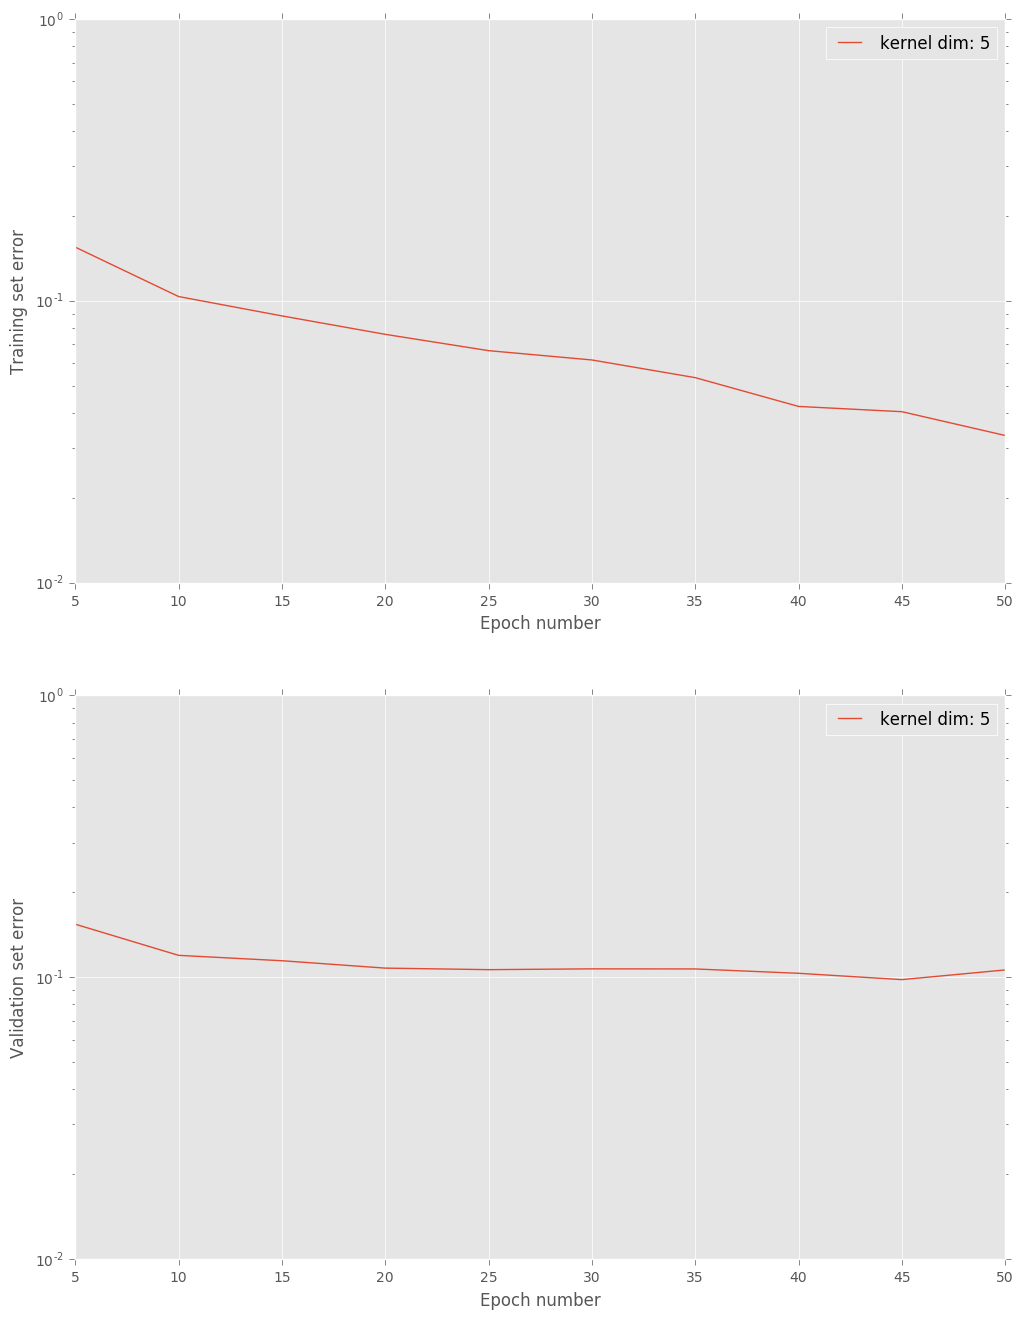

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(np.arange(1, aug_stats1.shape[0]) * stats_interval, 
        aug_stats1[1:, aug_keys1['error(train)']], label='kernel dim: 5')
ax2.plot(np.arange(1, aug_stats1.shape[0]) * stats_interval, 
             aug_stats1[1:, aug_keys1['error(valid)']], label='kernel dim: 5')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')
plt.show()
fig.tight_layout()
fig.savefig('-ex_fig_1.pdf')

In [16]:
input_dim_1 = 28
input_dim_2 = 28
hidden_dim = 100
num_input_channels = 1
num_output_channels = 1
kernel_dim_1 = 9
kernel_dim_2 = 9

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()
print('Kernel dim: {0}'.format(kernel_dim_1))
model = MultipleLayerModel([
    ReshapeLayer((1, 28, 28)),
    ConvolutionalLayer(num_input_channels, num_output_channels, input_dim_1, input_dim_2, kernel_dim_1, kernel_dim_2),
    MaxPoolingLayer(4),
    ReshapeLayer(),
    AffineLayer(((input_dim_1 - kernel_dim_1 + 1) ** 2) / 4, hidden_dim, weights_init, 
                biases_init),
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, 
                biases_init),
    SigmoidLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, 
                biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors)

aug_stats2, aug_keys2, aug_run_time2 = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

Kernel dim: 9


Epoch 5: 47.35s to complete
  error(train)=1.49e-01, acc(train)=9.58e-01, error(valid)=1.47e-01, acc(valid)=9.57e-01, params_penalty=0.00e+00
Epoch 10: 45.06s to complete
  error(train)=9.30e-02, acc(train)=9.74e-01, error(valid)=1.13e-01, acc(valid)=9.68e-01, params_penalty=0.00e+00
Epoch 15: 44.70s to complete
  error(train)=6.73e-02, acc(train)=9.81e-01, error(valid)=9.83e-02, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 20: 45.74s to complete
  error(train)=4.80e-02, acc(train)=9.87e-01, error(valid)=9.06e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 25: 46.07s to complete
  error(train)=3.84e-02, acc(train)=9.90e-01, error(valid)=9.14e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 30: 44.84s to complete
  error(train)=3.02e-02, acc(train)=9.92e-01, error(valid)=9.21e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 35: 45.03s to complete
  error(train)=2.58e-02, acc(train)=9.94e-01, error(valid)=9.56e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00


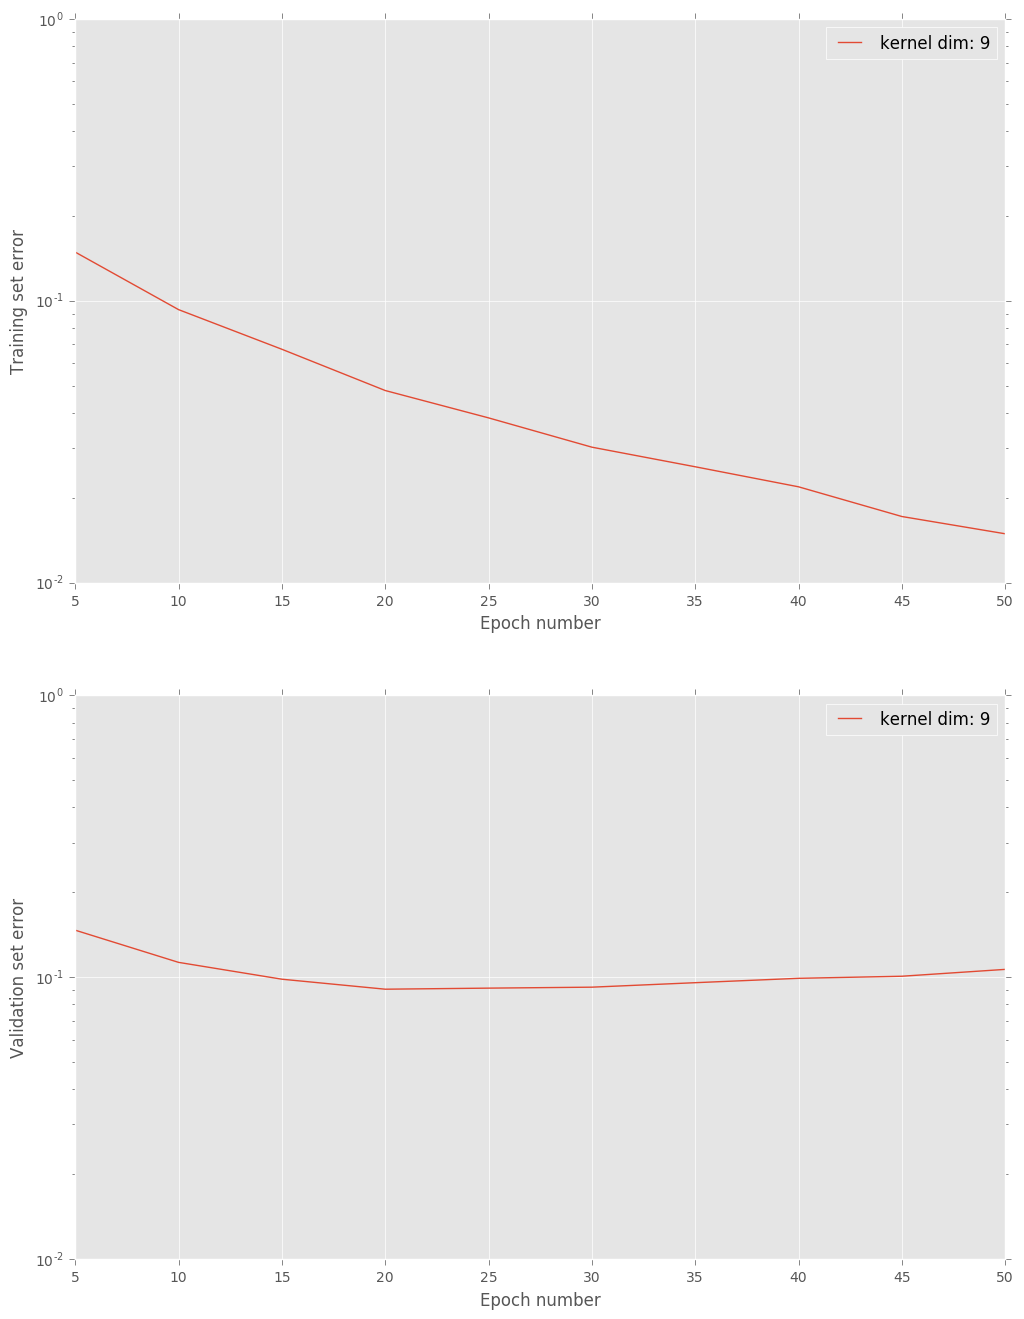

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(np.arange(1, aug_stats2.shape[0]) * stats_interval, 
        aug_stats2[1:, aug_keys2['error(train)']], label='kernel dim: 9')
ax2.plot(np.arange(1, aug_stats2.shape[0]) * stats_interval, 
             aug_stats2[1:, aug_keys2['error(valid)']], label='kernel dim: 9')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')
plt.show()
fig.tight_layout()
fig.savefig('-ex_fig_2.pdf')

In [27]:
input_dim_1 = 28
input_dim_2 = 28
hidden_dim = 100
num_input_channels = 1
num_output_channels = 1
kernel_dim_1 = 5
kernel_dim_2 = 5

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()
print('Pool size: {0}'.format('8'))
model = MultipleLayerModel([
    ReshapeLayer((1, 28, 28)),
    ConvolutionalLayer(num_input_channels, num_output_channels, input_dim_1, input_dim_2, kernel_dim_1, kernel_dim_2),
    MaxPoolingLayer(8),
    ReshapeLayer(),
    AffineLayer(((input_dim_1 - kernel_dim_1 + 1) ** 2) / 8, hidden_dim, weights_init, 
                biases_init),
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, 
                biases_init),
    SigmoidLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, 
                biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors)

aug_stats3, aug_keys3, aug_run_time3 = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

Pool size: 8


Epoch 5: 36.44s to complete
  error(train)=2.26e-01, acc(train)=9.32e-01, error(valid)=2.11e-01, acc(valid)=9.38e-01, params_penalty=0.00e+00
Epoch 10: 36.43s to complete
  error(train)=2.11e-01, acc(train)=9.33e-01, error(valid)=2.01e-01, acc(valid)=9.39e-01, params_penalty=0.00e+00
Epoch 15: 35.82s to complete
  error(train)=1.98e-01, acc(train)=9.38e-01, error(valid)=1.94e-01, acc(valid)=9.41e-01, params_penalty=0.00e+00
Epoch 20: 36.17s to complete
  error(train)=1.86e-01, acc(train)=9.41e-01, error(valid)=1.89e-01, acc(valid)=9.41e-01, params_penalty=0.00e+00
Epoch 25: 36.24s to complete
  error(train)=1.64e-01, acc(train)=9.49e-01, error(valid)=1.72e-01, acc(valid)=9.47e-01, params_penalty=0.00e+00
Epoch 30: 39.47s to complete
  error(train)=1.65e-01, acc(train)=9.47e-01, error(valid)=1.78e-01, acc(valid)=9.44e-01, params_penalty=0.00e+00
Epoch 35: 36.95s to complete
  error(train)=1.60e-01, acc(train)=9.51e-01, error(valid)=1.70e-01, acc(valid)=9.50e-01, params_penalty=0.00e+00


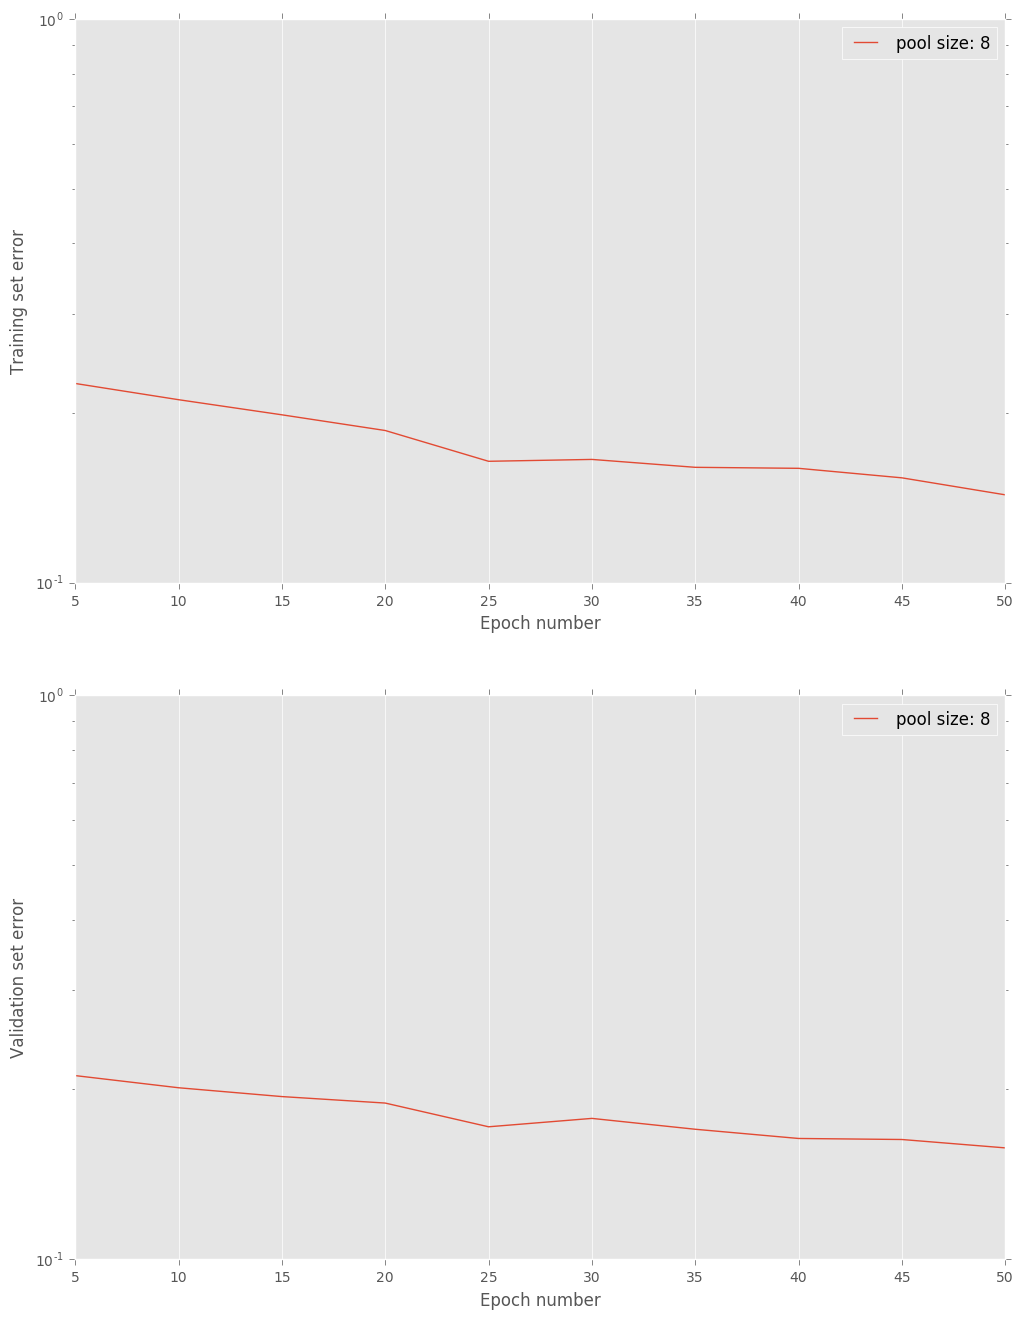

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(np.arange(1, aug_stats3.shape[0]) * stats_interval, 
        aug_stats3[1:, aug_keys3['error(train)']], label='pool size: 8')
ax2.plot(np.arange(1, aug_stats3.shape[0]) * stats_interval, 
             aug_stats3[1:, aug_keys3['error(valid)']], label='pool size: 8')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')
plt.show()
fig.tight_layout()
fig.savefig('-ex_fig_3.pdf')

In [6]:
input_dim_1 = 28
input_dim_2 = 28
hidden_dim = 100
num_input_channels = 1
num_output_channels = 1
kernel_dim_1 = 5
kernel_dim_2 = 5

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()
print('No maxpooling layer')
model = MultipleLayerModel([
    ReshapeLayer((1, 28, 28)),
    ConvolutionalLayer(num_input_channels, num_output_channels, input_dim_1, input_dim_2, kernel_dim_1, kernel_dim_2),
    ReshapeLayer(),
    AffineLayer(((input_dim_1 - kernel_dim_1 + 1) ** 2), hidden_dim, weights_init, 
                biases_init),
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, 
                biases_init),
    SigmoidLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, 
                biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors)

aug_stats4, aug_keys4, aug_run_time4 = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

No maxpooling layer


Epoch 5: 35.57s to complete
  error(train)=1.32e-01, acc(train)=9.63e-01, error(valid)=1.39e-01, acc(valid)=9.61e-01, params_penalty=0.00e+00
Epoch 10: 35.75s to complete
  error(train)=6.87e-02, acc(train)=9.82e-01, error(valid)=1.02e-01, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 15: 36.05s to complete
  error(train)=3.47e-02, acc(train)=9.93e-01, error(valid)=8.53e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 20: 36.81s to complete
  error(train)=2.29e-02, acc(train)=9.96e-01, error(valid)=8.68e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 25: 36.32s to complete
  error(train)=1.34e-02, acc(train)=9.98e-01, error(valid)=8.77e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 30: 36.02s to complete
  error(train)=8.89e-03, acc(train)=9.99e-01, error(valid)=8.97e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 35: 36.69s to complete
  error(train)=6.15e-03, acc(train)=9.99e-01, error(valid)=9.16e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00


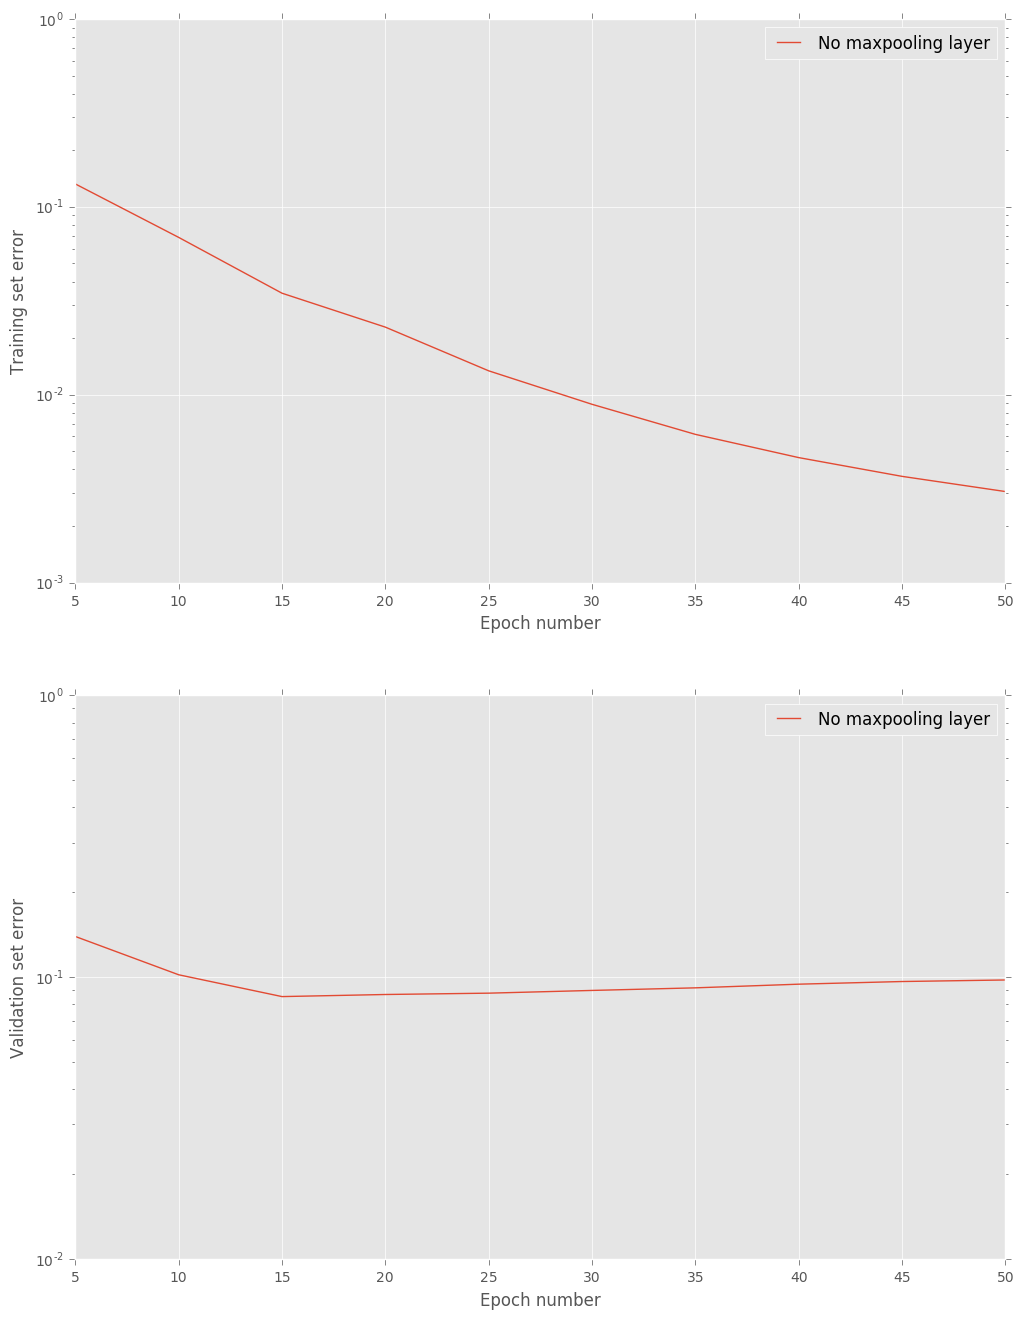

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(np.arange(1, aug_stats4.shape[0]) * stats_interval, 
        aug_stats4[1:, aug_keys4['error(train)']], label='No maxpooling layer')
ax2.plot(np.arange(1, aug_stats4.shape[0]) * stats_interval, 
             aug_stats4[1:, aug_keys4['error(valid)']], label='No maxpooling layer')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')
plt.show()
fig.tight_layout()
fig.savefig('-ex_fig_4.pdf')

In [8]:
input_dim_1 = 28
input_dim_2 = 28
hidden_dim = 100
num_input_channels = 1
num_output_channels = 1
kernel_dim_1 = 5
kernel_dim_2 = 5

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()
print('using one affine layer')
model = MultipleLayerModel([
    ReshapeLayer((1, 28, 28)),
    ConvolutionalLayer(num_input_channels, num_output_channels, input_dim_1, input_dim_2, kernel_dim_1, kernel_dim_2),
    MaxPoolingLayer(8),
    ReshapeLayer(),
    AffineLayer(((input_dim_1 - kernel_dim_1 + 1) ** 2) / 8, output_dim, weights_init, 
                biases_init),
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors)

aug_stats5, aug_keys5, aug_run_time5 = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

using one affine layer


Epoch 5: 35.99s to complete
  error(train)=4.05e-01, acc(train)=8.81e-01, error(valid)=3.64e-01, acc(valid)=8.93e-01, params_penalty=0.00e+00
Epoch 10: 35.67s to complete
  error(train)=4.11e-01, acc(train)=8.85e-01, error(valid)=3.78e-01, acc(valid)=8.94e-01, params_penalty=0.00e+00
Epoch 15: 34.94s to complete
  error(train)=4.13e-01, acc(train)=8.81e-01, error(valid)=3.75e-01, acc(valid)=8.91e-01, params_penalty=0.00e+00
Epoch 20: 35.11s to complete
  error(train)=4.09e-01, acc(train)=8.82e-01, error(valid)=3.74e-01, acc(valid)=8.94e-01, params_penalty=0.00e+00
Epoch 25: 34.66s to complete
  error(train)=3.78e-01, acc(train)=8.95e-01, error(valid)=3.52e-01, acc(valid)=9.03e-01, params_penalty=0.00e+00
Epoch 30: 34.79s to complete
  error(train)=4.48e-01, acc(train)=8.78e-01, error(valid)=4.17e-01, acc(valid)=8.90e-01, params_penalty=0.00e+00
Epoch 35: 35.14s to complete
  error(train)=4.06e-01, acc(train)=8.86e-01, error(valid)=3.77e-01, acc(valid)=8.95e-01, params_penalty=0.00e+00


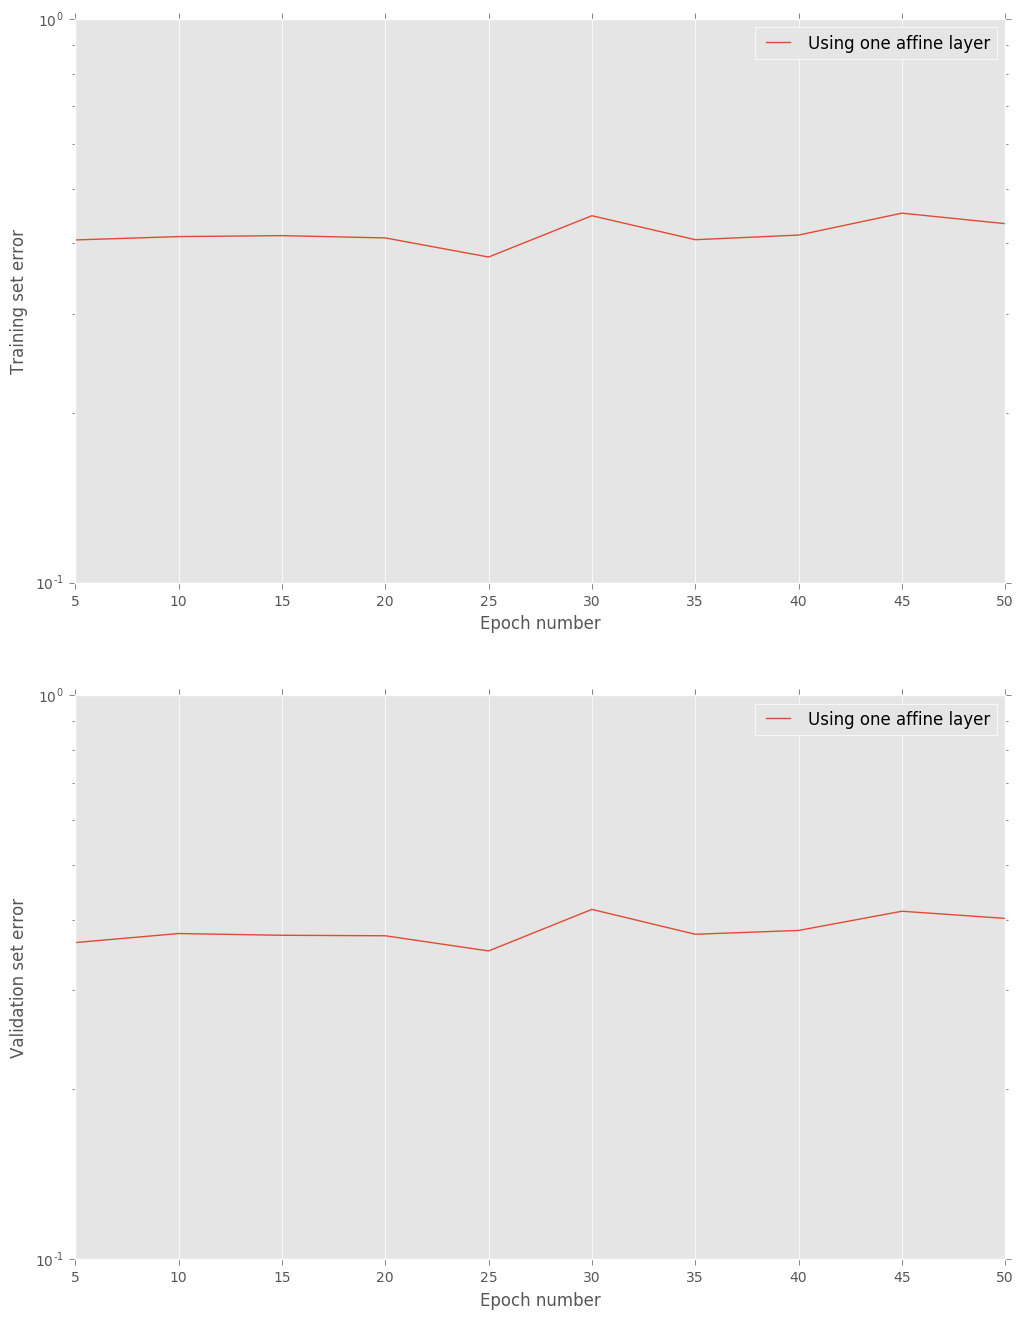

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(np.arange(1, aug_stats5.shape[0]) * stats_interval, 
        aug_stats5[1:, aug_keys5['error(train)']], label='Using one affine layer')
ax2.plot(np.arange(1, aug_stats5.shape[0]) * stats_interval, 
             aug_stats5[1:, aug_keys5['error(valid)']], label='Using one affine layer')
ax1.legend(loc='best')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc='best')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')
plt.show()
fig.tight_layout()
fig.savefig('-ex_fig_5.pdf')